In [1]:
import numpy as np
import json

In [2]:
train_path = '../data/train_data.json'
dev_path = '../data/dev_data.json'
schema_path = '../data/all_50_schemas'

In [3]:
train = []
with open(train_path, 'r', encoding='utf8') as f:
    for line in f:
        train.append(json.loads(line.strip()))

col_name | des
- | -
text | raw text
max_triples | max triple number
has_postag | 

In [4]:
text = []
num_triples = []
has_postag = []
for sample in train:
    text_ = sample['text']
    num_triples_ = len(sample['spo_list'])
    has_postag_ = (len(sample['postag']) > 0)
    text.append(text_)
    num_triples.append(num_triples_)
    has_postag.append(has_postag_)

In [5]:
import pandas as pd

In [6]:
train_df = pd.DataFrame(data={'text': text, 'num_triple': num_triples, 'has_postag': has_postag})

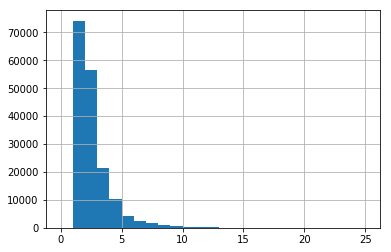

In [16]:
# 三元组个数分布
train_df['num_triple'].hist(bins=25)

In [31]:
train_df.groupby('num_triple').count()

,has_postag,text
num_triple,,
0,13,13
1,74169,74169
2,56611,56611
3,21300,21300
4,10177,10177
5,4393,4393
6,2296,2296
7,1594,1594
8,933,933


In [28]:
# 不含有postag 的sample个数
train_df['has_postag'].sum() / train_df['has_postag'].count()

0.9997111629734039

In [22]:
# 最大句子长度
max(map(len, text))

300

In [36]:
# 统计关系类型出现频次
from collections import defaultdict
train_rel = defaultdict(int)
for sample in train:
    spo_list = sample['spo_list']
    for spo in spo_list:
        predi = spo['predicate']
        train_rel[predi] += 1
        
dev_rel = defaultdict(int)
for sample in dev:
    spo_list = sample['spo_list']
    for spo in spo_list:
        predi = spo['predicate']
        dev_rel[predi] += 1
        

In [40]:
train_rel = sorted(train_rel.items(), key=lambda x: x[1], reverse=True)
dev_rel = sorted(dev_rel.items(), key=lambda x: x[1], reverse=True)

In [62]:
import matplotlib.pyplot as plt
# 指定默认字体
plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams['font.family']='sans-serif' 
# 用来正常显示负号
plt.rcParams['axes.unicode_minus']=False


/home/luban/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


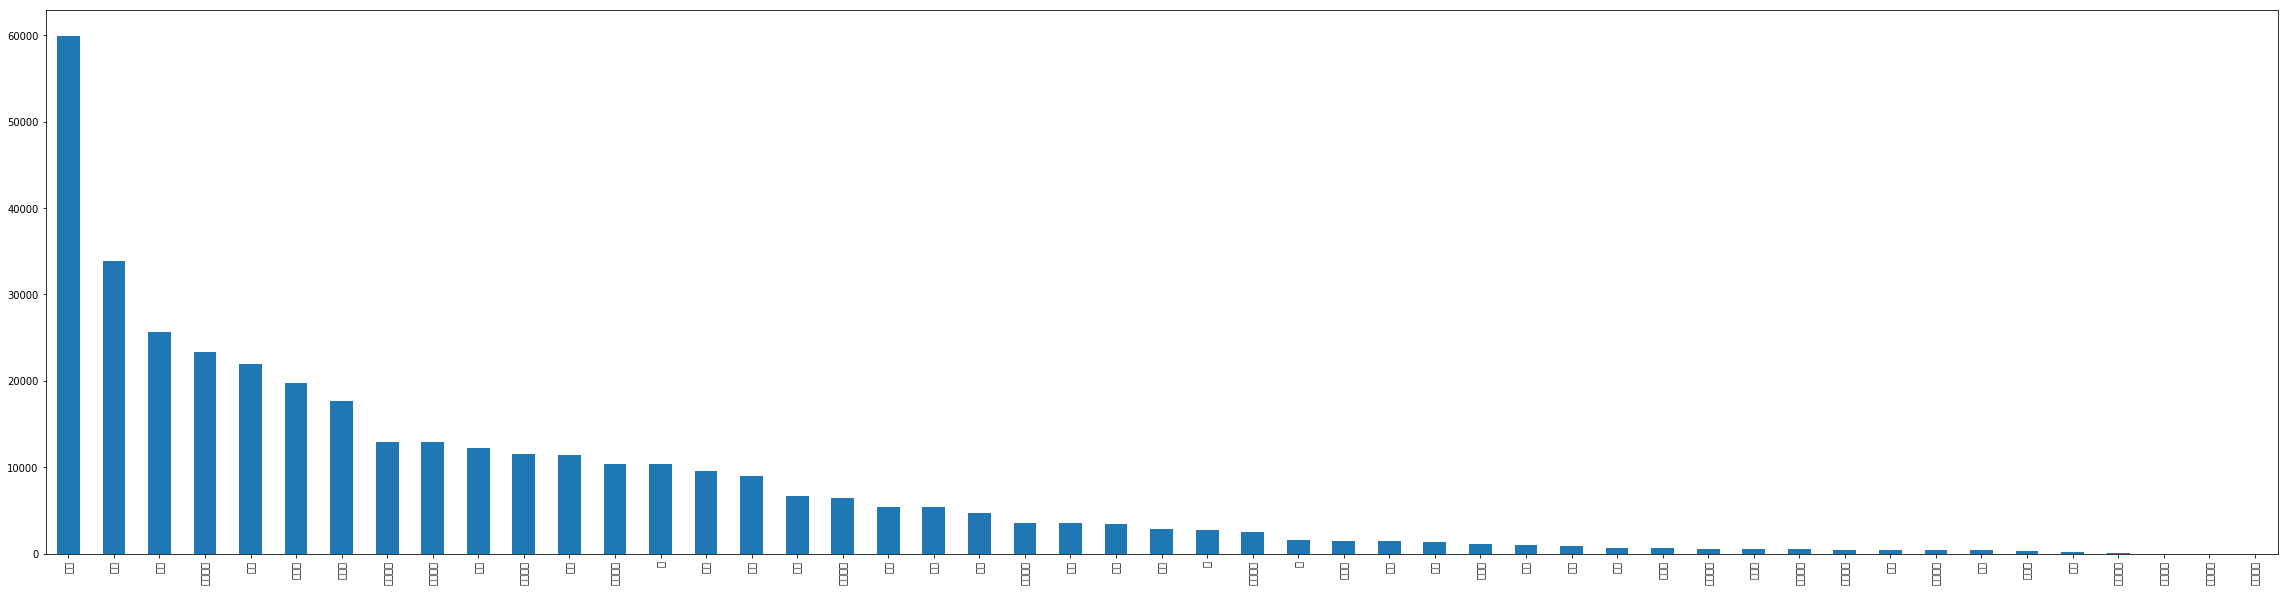

In [64]:
train_rel_ser = pd.Series(list(zip(*train_rel))[1], index=list(zip(*train_rel))[0])
train_rel_ser.plot.bar(figsize=(40, 10))

In [67]:
train_rel

[('主演', 59893),
 ('作者', 33853),
 ('歌手', 25605),
 ('出生日期', 23290),
 ('导演', 22007),
 ('出生地', 19813),
 ('出版社', 17709),
 ('成立日期', 12906),
 ('连载网站', 12877),
 ('国籍', 12261),
 ('毕业院校', 11515),
 ('民族', 11453),
 ('所属专辑', 10402),
 ('目', 10342),
 ('作曲', 9607),
 ('作词', 9046),
 ('编剧', 6667),
 ('出品公司', 6419),
 ('妻子', 5462),
 ('丈夫', 5462),
 ('父亲', 4701),
 ('上映时间', 3522),
 ('母亲', 3516),
 ('朝代', 3433),
 ('身高', 2905),
 ('字', 2733),
 ('总部地点', 2466),
 ('号', 1551),
 ('主持人', 1511),
 ('祖籍', 1492),
 ('嘉宾', 1368),
 ('制片人', 1160),
 ('简称', 1008),
 ('气候', 920),
 ('面积', 660),
 ('创始人', 633),
 ('所在城市', 575),
 ('改编自', 553),
 ('占地面积', 502),
 ('人口数量', 409),
 ('首都', 397),
 ('注册资本', 397),
 ('海拔', 383),
 ('董事长', 368),
 ('主角', 250),
 ('官方语言', 145),
 ('专业代码', 26),
 ('邮政编码', 25),
 ('修业年限', 20)]

In [ ]:
def get_tri(data):
    raw_tri = []
    pro_tri = []
    nor = []
    olp = []
    mul = []
    nest = []
    no_sub = []
    no_obj = []
    for sample in data:
        spo_list = data['spo_list']
        rsl = []
        psl = []
        text = data['text']
        no_sub = False
        no_obj = False
        for spo in spo_list:
            sub = spo['subject']
            obj = spo['object']
            pre = spo['predicate']
            preid = schema2id[pre]
            subs = text.find(sub)
            sube = subs + len(sub) - 1
            objs = text.find(obj)
            obje = objs + len(obj) - 1
            if subs == -1:
                
                
        

In [34]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [14]:
pp.pprint(train[np.random.randint(len(train))])

{   'postag': [   {'pos': 't', 'word': '现在'},
                  {'pos': 'w', 'word': '，'},
                  {'pos': 'v', 'word': '历经'},
                  {'pos': 'n', 'word': '鑫涛'},
                  {'pos': 'w', 'word': '（'},
                  {'pos': 'nr', 'word': '平鑫涛'},
                  {'pos': 'w', 'word': '，'},
                  {'pos': 'nr', 'word': '琼瑶'},
                  {'pos': 'u', 'word': '的'},
                  {'pos': 'n', 'word': '丈夫'},
                  {'pos': 'w', 'word': '）'},
                  {'pos': 'v', 'word': '失智'},
                  {'pos': 'w', 'word': '、'},
                  {'pos': 'nz', 'word': '中风'},
                  {'pos': 'w', 'word': '、'},
                  {'pos': 'vn', 'word': '插管'},
                  {'pos': 'u', 'word': '的'},
                  {'pos': 'n', 'word': '风波'},
                  {'pos': 'f', 'word': '后'},
                  {'pos': 'w', 'word': '，'},
                  {'pos': 'r', 'word': '我'},
                  {'pos': 'v', 'word': '

In [32]:
dev = []
with open(dev_path, 'r', encoding='utf8') as f:
    for line in f:
        dev.append(json.loads(line.strip()))

In [35]:
pp.pprint(dev[np.random.randint(len(dev))])

{   'postag': [   {'pos': 'c', 'word': '若'},
                  {'pos': 'v', 'word': '说'},
                  {'pos': 'nr', 'word': '金庸'},
                  {'pos': 'd', 'word': '最'},
                  {'pos': 'n', 'word': '巅峰'},
                  {'pos': 'd', 'word': '又'},
                  {'pos': 'd', 'word': '最'},
                  {'pos': 'v', 'word': '颠覆'},
                  {'pos': 'u', 'word': '的'},
                  {'pos': 'm', 'word': '一本'},
                  {'pos': 'n', 'word': '武侠'},
                  {'pos': 'n', 'word': '小说'},
                  {'pos': 'v', 'word': '是'},
                  {'pos': 'w', 'word': '《'},
                  {'pos': 'nw', 'word': '鹿鼎记'},
                  {'pos': 'w', 'word': '》'},
                  {'pos': 'w', 'word': '，'},
                  {'pos': 'c', 'word': '那么'},
                  {'pos': 'r', 'word': '我'},
                  {'pos': 'v', 'word': '觉得'},
                  {'pos': 'w', 'word': '《'},
                  {'pos': 'nw', 'word': '欢乐

In [23]:
schemas = []
with open(schema_path, 'r', encoding='utf8') as f:
    for line in f:
        schemas.append(json.loads(line.strip()))

In [69]:
schemas

[{'object_type': '地点', 'predicate': '祖籍', 'subject_type': '人物'},
 {'object_type': '人物', 'predicate': '父亲', 'subject_type': '人物'},
 {'object_type': '地点', 'predicate': '总部地点', 'subject_type': '企业'},
 {'object_type': '地点', 'predicate': '出生地', 'subject_type': '人物'},
 {'object_type': '目', 'predicate': '目', 'subject_type': '生物'},
 {'object_type': 'Number', 'predicate': '面积', 'subject_type': '行政区'},
 {'object_type': 'Text', 'predicate': '简称', 'subject_type': '机构'},
 {'object_type': 'Date', 'predicate': '上映时间', 'subject_type': '影视作品'},
 {'object_type': '人物', 'predicate': '妻子', 'subject_type': '人物'},
 {'object_type': '音乐专辑', 'predicate': '所属专辑', 'subject_type': '歌曲'},
 {'object_type': 'Number', 'predicate': '注册资本', 'subject_type': '企业'},
 {'object_type': '城市', 'predicate': '首都', 'subject_type': '国家'},
 {'object_type': '人物', 'predicate': '导演', 'subject_type': '影视作品'},
 {'object_type': 'Text', 'predicate': '字', 'subject_type': '历史人物'},
 {'object_type': 'Number', 'predicate': '身高', 'subject_type':

In [78]:
a = Counter([x['predicate'] for x in schemas])
b = set([x[0] for x in train_rel])

In [77]:
from collections import Counter

In [79]:
# 成立日期有两个，企业和机构，总共有49个schema
a

Counter({'丈夫': 1,
         '上映时间': 1,
         '专业代码': 1,
         '主持人': 1,
         '主演': 1,
         '主角': 1,
         '人口数量': 1,
         '作曲': 1,
         '作者': 1,
         '作词': 1,
         '修业年限': 1,
         '出品公司': 1,
         '出版社': 1,
         '出生地': 1,
         '出生日期': 1,
         '创始人': 1,
         '制片人': 1,
         '占地面积': 1,
         '号': 1,
         '嘉宾': 1,
         '国籍': 1,
         '妻子': 1,
         '字': 1,
         '官方语言': 1,
         '导演': 1,
         '总部地点': 1,
         '成立日期': 2,
         '所在城市': 1,
         '所属专辑': 1,
         '改编自': 1,
         '朝代': 1,
         '歌手': 1,
         '母亲': 1,
         '毕业院校': 1,
         '民族': 1,
         '气候': 1,
         '注册资本': 1,
         '海拔': 1,
         '父亲': 1,
         '目': 1,
         '祖籍': 1,
         '简称': 1,
         '编剧': 1,
         '董事长': 1,
         '身高': 1,
         '连载网站': 1,
         '邮政编码': 1,
         '面积': 1,
         '首都': 1})

In [90]:
id2schema = [x[0] for x in train_rel]

In [91]:
schema2id = {}
for i, s in enumerate(id2schema):
    schema2id[s] = i

In [93]:
with open('schema_vocab.txt', 'w', encoding='utf8') as f:
    for x in train_rel:
        f.write('{}\t{}\n'.format(x[0], x[1]))